In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn.utils as utils

## 1. Preparation

In [2]:
# Load the data
df = pd.read_csv('hourly_trip_counts.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort data by date and hour
df = df.sort_values(by=['date', 'hour']).reset_index(drop=True)

# Normalize the count values
scaler = MinMaxScaler()
df['count'] = scaler.fit_transform(df['count'].values.reshape(-1, 1))

In [3]:
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Sequence length, here we choose 24h
data = df['count'].values
X, y = create_sequences(data, SEQ_LENGTH)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Reshape tensors for LSTM input (batch_size, seq_length, num_features)
""" 
Unsquee turn a tensor by adding an extra dimension of depth 1, note that the number of dim
"""
X_train_tensor = X_train_tensor.unsqueeze(-1)
X_test_tensor = X_test_tensor.unsqueeze(-1)

# Display data shapes
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([6988, 24, 1]),
 torch.Size([6988]),
 torch.Size([1747, 24, 1]),
 torch.Size([1747]))

## 2. Define the MDN part

Define the MDN layer

In [4]:

class MDNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_gaussians):
        super(MDNLayer, self).__init__()
        self.num_gaussians = num_gaussians

        # Establish three fully connected layers from input_dim to num_gaussians
        # Caculate the weights of the mixture of Gaussian distribution
        self.z_pi = nn.Linear(input_dim, num_gaussians)
        self.z_sigma = nn.Linear(input_dim, num_gaussians * output_dim) # Here actually output_dim is 1 beacuse it is the dimension of each Gaussian distribution ouput
        self.z_mu = nn.Linear(input_dim, num_gaussians * output_dim)

    # Here the keyword self in python is used to represent the instance of the class. It allow you to access attributes and methods of the class in object-oriented programming.
    # General Explanation of self: self is used to refer to the current instance of the class / By useing self, you can accsee other access other methods and attributes with the same class.
    def forward(self, x):
        # The softmax function is used to convert a vector of valuse into a probability distribution, where the sum of all probabilities is 
        pi = F.softmax(self.z_pi(x), dim=1) # dim=1 is because we ensure that the softmax funtion is applied independently to each sample in the batch.
        sigma = torch.exp(self.z_sigma(x)) # this ensures that the output standard sigman is always postive.
        mu = self.z_mu(x)

        
        return pi, sigma, mu

**LSTMMDN  Model**

In [5]:
# Modify the LSTM model
class LSTMMDNModel(nn.Module):
    # Here the number of Gaussians determines the flexibility of the model in representing complex distributions.Generally, more Gaussians allow the model to fit more complex and multimodel distribution
    def __init__(self, input_size=1, output_size=1, num_gaussians=10): 
        super(LSTMMDNModel, self).__init__()
        
        self.num_gaussians = num_gaussians
        self.hidden_layer_size = 128
        # The input and output tensor provided to the model will have the format like 'shape(batch, seq, feature)'
        self.lstm = nn.LSTM(input_size, self.hidden_layer_size, num_layers=2, batch_first=True, dropout=0.1)
        self.mdn = MDNLayer(self.hidden_layer_size, output_size, num_gaussians)


    def forward(self, input_seq):

        # When an lstm processes an input sequence, it outputs a tensor that contains the hidden states for each timestep in the sequence. 
        # The output tensor has the shape (batch_size, sequence_length, hidden_layer_size)
        batch_size = input_seq.size(0)
        h_0 = torch.zeros(2, batch_size, self.hidden_layer_size).to(input_seq.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_layer_size).to(input_seq.device)
        
        lstm_out, _ = self.lstm(input_seq, (h_0, c_0))

        lstm_out = lstm_out[:, -1, :] # We choose the hidden state of the last time step for each sequence in the batch, which summerize representation of the entire input sequence
        pi, sigma, mu = self.mdn(lstm_out)
        return pi, sigma, mu


**Define the MDN loss funtion**

The loss function is implementing a form of the negative log_likelihood loss for a mixture of Gaussian distribution. This approach measures how well the predicted probability distribution explains the observed data points.

In [6]:
def mdn_loss(pi, sigma, mu, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma) # This code creates a set of normal distribution parameterized by mu and sigma
    y = y.unsqueeze(1).expand(y.size(0), 10)  # Transform y to have the shape ((batch_size, num_gaussians, num_gaussians * output_dim))

    #Here we use a numerically stable computation method when calculating sum of exponential. 
    loss = torch.logsumexp(torch.log(pi) + m.log_prob(y), dim=1)  # shape (batch_size, output_size)
    return -torch.mean(loss)


In [7]:
# Create the dataset and dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Randomly shuffle the data at the beginning of each training cycle (epoch), avoiding overfitting during training

# Initialize the model, the loss function and optimizer

model = LSTMMDNModel()

# Here the learning rate is 0.001
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Set the number of epochs
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for seq, label in data_loader:
        optimizer.zero_grad()  # 清除旧的梯度

        pi, sigma, mu = model(seq)  # 现在 forward 方法会自动调整隐藏状态大小

    

        loss = mdn_loss(pi, sigma, mu, label)
        # After loss.backward()
        loss.backward()

        optimizer.step()  # 更新所有参数

        train_loss += loss.item() * batch_size

    train_losses.append(train_loss / len(X_train_tensor))

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Train Loss: {train_losses[-1]}')

print(f'Final Train Loss: {train_losses[-1]}')


Epoch 0 Train Loss: 1.0515213351148704
Epoch 10 Train Loss: -0.22864665760609104
Epoch 20 Train Loss: -0.27446876148121246
Epoch 30 Train Loss: -0.29853491716270253
Epoch 40 Train Loss: -0.32284707223338677
Final Train Loss: -0.3453841145269244


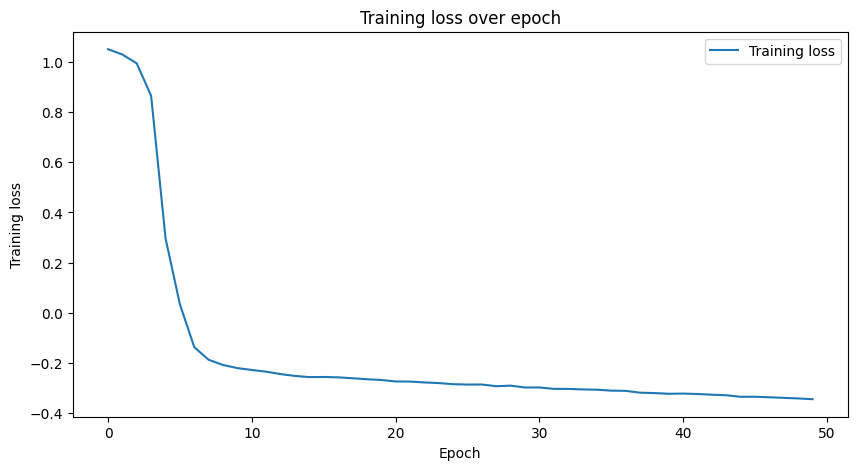

In [13]:
# Visualize the training loss

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epoch')
plt.legend()
plt.show()

Index 2, Loss: 0.8080767393112183
Pi: tensor([[0.0692, 0.1763, 0.0089, 0.1591, 0.1144, 0.0424, 0.0111, 0.3822, 0.0261,
         0.0103]]), Sigma: tensor([[0.1174, 0.0301, 0.1404, 0.0993, 0.0883, 0.1377, 0.1377, 0.0574, 0.1428,
         0.1446]]), Mu: tensor([[0.3646, 0.0467, 0.4107, 0.7030, 0.2176, 0.5131, 0.3888, 0.6005, 0.4289,
         0.4602]])
Index 3, Loss: 0.3795907199382782
Pi: tensor([[0.0694, 0.1763, 0.0090, 0.1592, 0.1143, 0.0425, 0.0112, 0.3815, 0.0262,
         0.0104]]), Sigma: tensor([[0.1180, 0.0304, 0.1410, 0.0998, 0.0889, 0.1383, 0.1383, 0.0578, 0.1432,
         0.1452]]), Mu: tensor([[0.3627, 0.0436, 0.4101, 0.6978, 0.2182, 0.5111, 0.3895, 0.5920, 0.4278,
         0.4583]])
Index 4, Loss: 0.47270750999450684
Pi: tensor([[0.0696, 0.1763, 0.0090, 0.1593, 0.1142, 0.0428, 0.0113, 0.3808, 0.0264,
         0.0105]]), Sigma: tensor([[0.1187, 0.0307, 0.1418, 0.1005, 0.0895, 0.1391, 0.1392, 0.0582, 0.1437,
         0.1461]]), Mu: tensor([[0.3614, 0.0416, 0.4095, 0.6931, 0.219

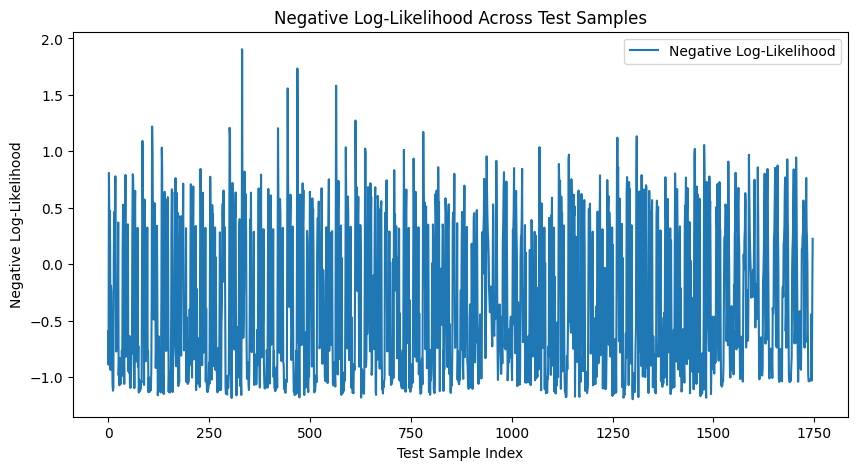

In [14]:
# Calculating negative log-likelihood for the test set
nll_losses = []
model.eval()
with torch.no_grad():
    for i in range(len(X_test_tensor)):
        seq = X_test_tensor[i:i+1]
        label = y_test_tensor[i:i+1]
        
        pi, sigma, mu = model(seq)
        loss = mdn_loss(pi, sigma, mu, label)

        if loss.item() > 0:
            print(f"Index {i}, Loss: {loss.item()}")
            print(f"Pi: {pi}, Sigma: {sigma}, Mu: {mu}")
            
        nll_losses.append(loss.item())

average_nll_loss = sum(nll_losses) / len(nll_losses)
print(f'Average Negative Log-Likelihood on Test Set: {average_nll_loss}')

plt.figure(figsize=(10, 5))
plt.plot(nll_losses, label='Negative Log-Likelihood')
plt.xlabel('Test Sample Index')
plt.ylabel('Negative Log-Likelihood')
plt.title('Negative Log-Likelihood Across Test Samples')
plt.legend()
plt.show()

In [15]:
percentage = sum(1 for x in nll_losses if x >= 0) / len(nll_losses)
percentage

0.3239839725243274

In [11]:
# # Saving the Model

# # Specify the path to save the model
# model_save_path = 'lstm_model.pth'

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_save_path)


In [12]:
# import torch

# # Initialize the model (make sure the model class definition is available)
# model = LSTMModel()

# # Load the model's state dictionary
# model_load_path = 'lstm_model.pth'
# model.load_state_dict(torch.load(model_load_path))

# # Set the model to evaluation mode
# model.eval()
